In [1]:
import numpy as np
import ipmlineq
import matplotlib.pyplot as plt
import cvxopt

%matplotlib inline

In [2]:
def scale_plot_size(factor=1.5):
    import matplotlib as mpl
    default_dpi = mpl.rcParamsDefault['figure.dpi']
    mpl.rcParams['figure.dpi'] = default_dpi*factor

scale_plot_size()

In [3]:
def obj(x, rho, A, b):
    e = np.dot(A, x) - b
    w = np.sqrt(rho + e ** 2)
    val = np.sum(w)
    g = np.dot(A.T, (e / w))
    H = A.T @ np.diag(rho / (w ** 3)) @ A
    return val, g, H

In [4]:
nx = 25
nk = 100
A = np.random.randn(nk, nx) / np.sqrt(nk)
b = 2.0*np.random.randn(nk)
rho = 0.10  # If this is smaller, it becomes harder to converge!
v, g, H = obj(np.random.randn(nx), rho, A, b)
print(v)
print(g)

if nx <= 10:
    print(H)

188.99596834996933
[-1.19959218  0.26111845 -0.16795258 -0.54562325  3.80583092 -1.19949014
 -0.13080952 -0.23826643  1.18990949  1.92972559  0.68447825  1.28953845
 -0.7243708  -0.69540617  0.34266273 -0.32912756 -1.20881521 -0.8915065
  0.40079761  0.32162916  1.199145    2.22087222  1.04830556 -1.27258148
 -1.37888104]


In [5]:
def F(x):
    v, g, H = obj(x, rho, A, b)
    return v, g, H

E = np.vstack([np.eye(nx), -1.0*np.eye(nx)])
f = np.hstack([np.ones(nx), np.ones(nx)])

In [6]:
unc_ls_sol = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, b))
clipped_ls_sol = np.array([np.max([-1+1e-12, np.min([e, 1-1e-12])]) for e in unc_ls_sol])
print(np.max(np.abs(unc_ls_sol - clipped_ls_sol)))
result = ipmlineq.solveDense(F, E, f, verbose = True, x0 = clipped_ls_sol, epstop = 1e-10)
print(result['converged'])
print(np.max(np.abs(unc_ls_sol - result['x'])))
print(np.max(np.abs(clipped_ls_sol - result['x'])))

4.457303738500154
mu(k=0) = 2.2360815673201353
mu(k=1) = 0.5684190168294415
mu(k=2) = 0.09533521332451173
mu(k=3) = 0.012271422056479962
mu(k=4) = 0.0014765595376313473
mu(k=5) = 0.00010849964996118046
mu(k=6) = 5.945440293258006e-06
mu(k=7) = 2.9668618082892773e-07
mu(k=8) = 1.483170344736083e-08
mu(k=9) = 7.415802706858909e-10
mu(k=10) = 3.7079016578869294e-11
mu(k=11) = 1.855655236452216e-12
True
4.457303738499087
1.8915055760992903


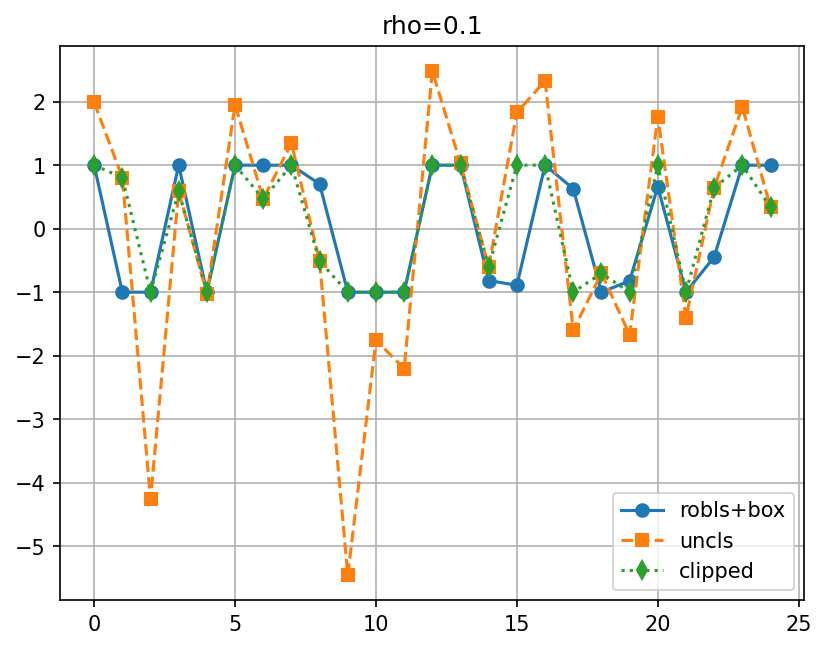

In [7]:
plt.plot(np.arange(nx), result['x'], label = 'robls+box', marker = 'o')
plt.plot(np.arange(nx), unc_ls_sol, label = 'uncls', linestyle = '--', marker = 's')
plt.plot(np.arange(nx), clipped_ls_sol, label = 'clipped', linestyle = ':', marker = 'd')
plt.title('rho={}'.format(rho))
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# http://cvxopt.org/userguide/solvers.html#problems-with-nonlinear-objectives

cvxopt.solvers.options['reltol'] = 1.0e-10

def robls(A, b, rho, E, f):
    m, n = A.size
    def F(x=None, z=None):
        if x is None: return 0, cvxopt.matrix(0.0, (n,1))
        y = A*x-b
        w = cvxopt.sqrt(rho + y**2)
        val = sum(w)
        Df = cvxopt.div(y, w).T * A
        if z is None: return val, Df
        H = A.T * cvxopt.spdiag(z[0]*rho*(w**-3)) * A
        return val, Df, H
    return cvxopt.solvers.cp(F, E, f)['x']

ref_sol_x = robls(cvxopt.matrix(A), cvxopt.matrix(b), rho, cvxopt.matrix(E), cvxopt.matrix(f))
ref_x = np.array(ref_sol_x).flatten()
print(np.max(np.abs(result['x'] - ref_x)))

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  1.2552e+02  5e+01  1e+00  1e+00
 1:  8.3579e+01  1.4521e+02  3e+01  5e-01  5e-01
 2:  1.2732e+02  1.5459e+02  1e+01  2e-01  2e-01
 3:  1.5198e+02  1.5965e+02  3e+00  6e-02  6e-02
 4:  1.5913e+02  1.6059e+02  9e-01  1e-02  2e-02
 5:  1.6065e+02  1.6084e+02  2e-01  2e-03  5e-03
 6:  1.6092e+02  1.6092e+02  3e-02  2e-04  1e-03
 7:  1.6094e+02  1.6094e+02  5e-03  2e-05  2e-04
 8:  1.6094e+02  1.6094e+02  4e-04  1e-06  2e-05
 9:  1.6094e+02  1.6094e+02  1e-05  4e-08  7e-07
10:  1.6094e+02  1.6094e+02  2e-07  5e-10  8e-09
11:  1.6094e+02  1.6094e+02  2e-09  5e-12  8e-11
Optimal solution found.
2.1807073702362345e-08


In [9]:
print(ref_x)
print(result['x'])

[ 1.         -0.99999998 -1.          1.         -1.          1.
  1.          1.          0.70277154 -1.         -1.         -1.
  1.          1.         -0.8166028  -0.89150556  1.          0.62922973
 -1.         -0.82192171  0.66402304 -1.         -0.4451131   1.
  0.99999999]
[ 1.         -1.         -1.          1.         -1.          1.
  1.          1.          0.70277154 -1.         -1.         -1.
  1.          1.         -0.8166028  -0.89150558  1.          0.62922973
 -1.         -0.82192171  0.66402303 -1.         -0.44511311  1.
  1.        ]
